In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras import optimizers
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Set data path
DATA_PATH = '../Datasets/'

# Check if the path exists and list files
if os.path.exists(DATA_PATH):
    print("Files in directory:", os.listdir(DATA_PATH))
else:
    print("Path does not exist:", DATA_PATH)

# Load the dataset
df = pd.read_csv(DATA_PATH + 'IOT-temp.csv')

# Display first few rows
df.head()

Files in directory: ['IOT-temp.csv']


,device_id,timestamp,sensor1
0,1,8/12/2018 9:30,29
1,1,8/12/2018 9:30,29
2,1,8/12/2018 9:29,41
3,1,8/12/2018 9:29,41
4,1,8/12/2018 9:29,31


In [4]:
# Define function to clean and normalize data
def clean_column_value(value):
    if value == '' or not any(char.isdigit() for char in str(value)):
        return 0.0
    cleaned_value = ''.join(filter(str.isdigit, str(value)))
    try:
        return float(cleaned_value)
    except ValueError:
        return 0.0

def normalize_data(df, col_not_to_norm):
    columns_to_normalize = df.columns.difference(col_not_to_norm)
    df_to_normalize = df[columns_to_normalize]
    df_not_to_normalize = df[col_not_to_norm]
    df_to_normalize = df_to_normalize.applymap(clean_column_value)
    scaler = StandardScaler()
    normalized_df = pd.DataFrame(scaler.fit_transform(df_to_normalize), columns=columns_to_normalize)
    return pd.concat([df_not_to_normalize, normalized_df], axis=1)

# Identify columns not to normalize
columns_not_to_normalize = ['device_id', 'timestamp']
df = normalize_data(df, columns_not_to_normalize)
df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20268\2676149156.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_to_normalize = df_to_normalize.applymap(clean_column_value)


,device_id,timestamp,sensor1
0,1,8/12/2018 9:30,-1.062131
1,1,8/12/2018 9:30,-1.062131
2,1,8/12/2018 9:29,1.043207
3,1,8/12/2018 9:29,1.043207
4,1,8/12/2018 9:29,-0.711241


Empty DataFrame
Columns: [device_id, timestamp, sensor1]
Index: []


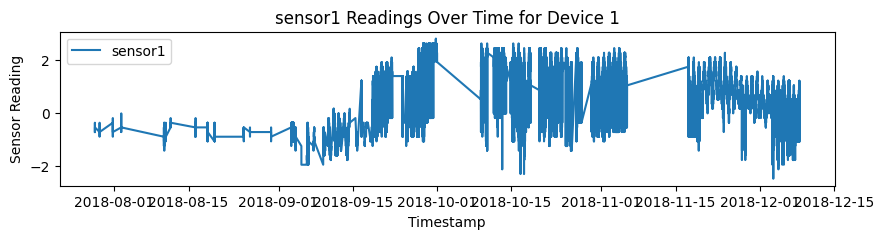

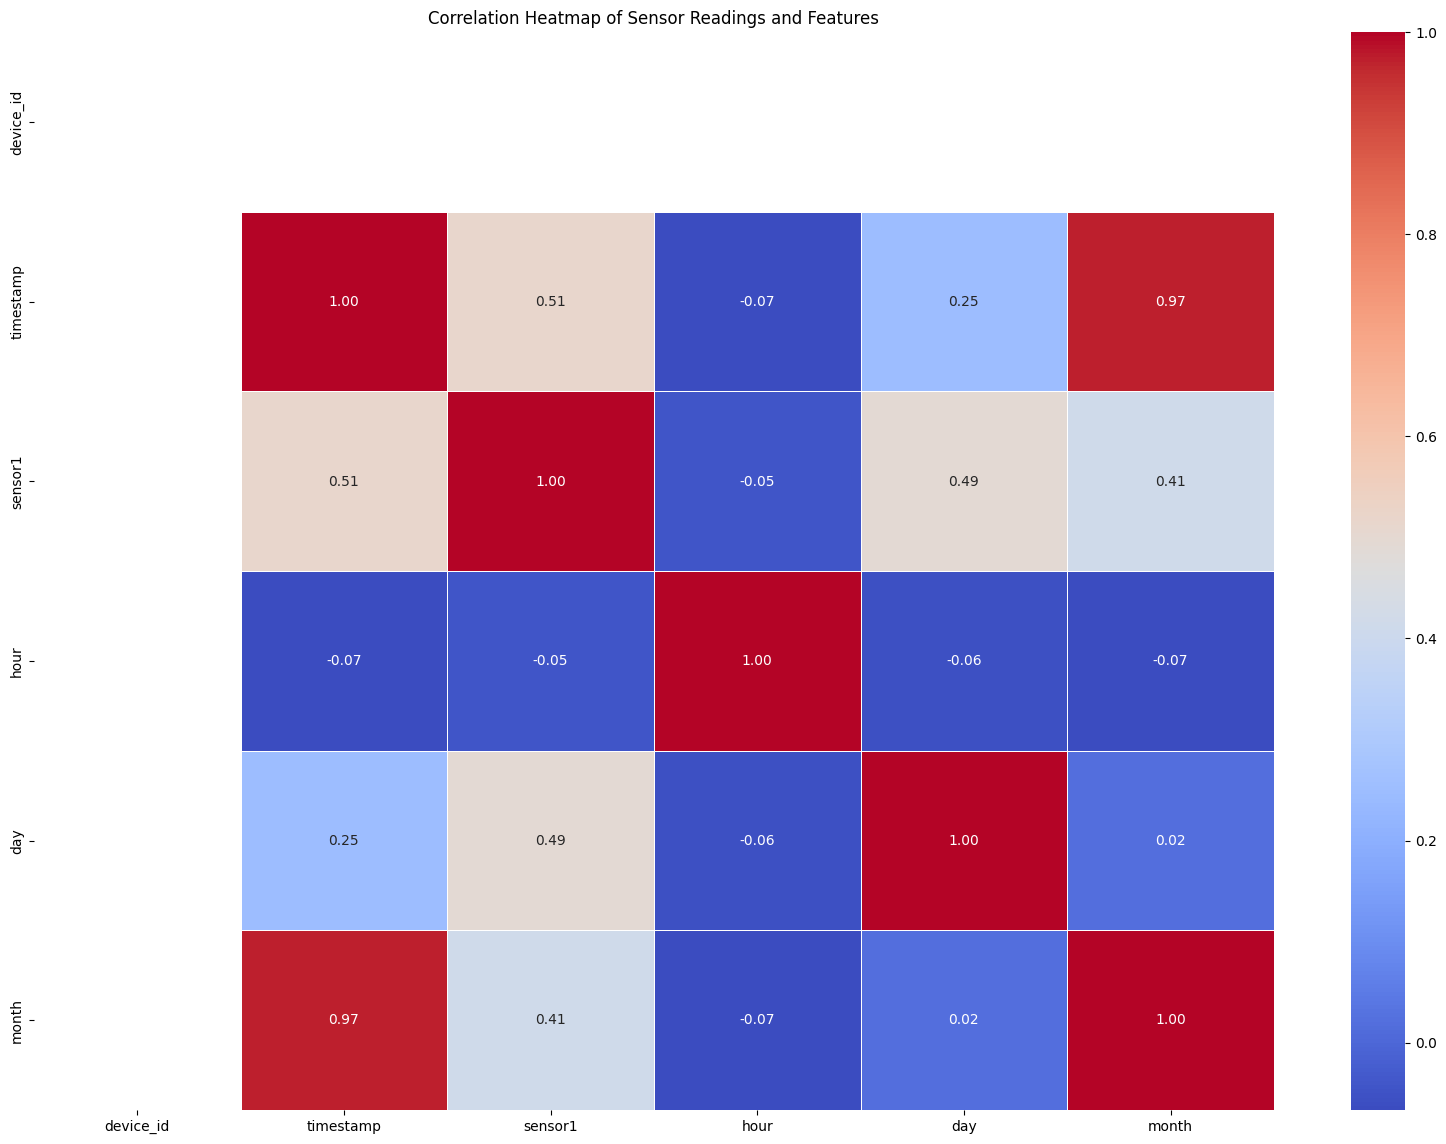

In [5]:
# Mengubah 'timestamp' menjadi datetime dengan menghandle error
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M')

# Cek apakah ada nilai NaT yang menandakan kesalahan format
print(df[df['timestamp'].isna()])

# Lanjutkan dengan operasi lain jika konversi waktu sudah sesuai
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month

# Continue with your visualizations and analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize sensor readings over time for a specific device
device_id = 1
device_data = df[df['device_id'] == device_id]
sensors = [col for col in df.columns if 'sensor' in col]

for sensor in sensors:
    plt.figure(figsize=(10, 2))
    plt.plot(device_data['timestamp'], device_data[sensor], label=sensor)
    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Reading')
    plt.title(f'{sensor} Readings Over Time for Device {device_id}')
    plt.legend()
    plt.show()

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Sensor Readings and Features')
plt.show()

D:\flask\FlaskPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - loss: 0.4818 - mae: 0.4853 - val_loss: 0.0350 - val_mae: 0.1559
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - loss: 0.2728 - mae: 0.3142 - val_loss: 0.0197 - val_mae: 0.1120
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - loss: 0.2651 - mae: 0.3054 - val_loss: 0.0158 - val_mae: 0.1016
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - loss: 0.2643 - mae: 0.3004 - val_loss: 0.0150 - val_mae: 0.1015
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - loss: 0.2622 - mae: 0.2947 - val_loss: 0.0266 - val_mae: 0.1339
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - loss: 0.2549 - mae: 0.2904 - val_loss: 0.0186 - val_mae: 0.1079
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - loss: 0.2513 - mae: 0.2855 - val_loss: 0.0176 - val_mae: 0.1061
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - loss: 0.2463 - mae: 0.2820 - val_loss: 0.0170 - val_mae: 0.1040
Epoch 9/10
352/352 ━━━━━━━━━━━━━

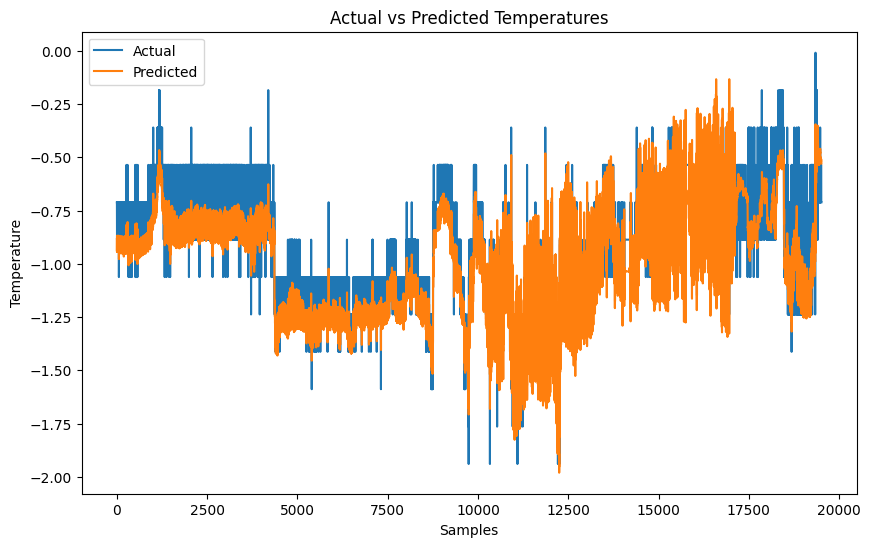

In [6]:
# Define sequence length
sequence_length = 50

# Function to generate sequences
def gen_sequence(df, seq_length, seq_cols):
    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]
    return np.array([data_array[i:i+seq_length] for i in range(num_elements-seq_length+1)])

# Generate sequences for training
sequence_cols = sensors + ['hour', 'day', 'month']
seq_list = [gen_sequence(df[df['device_id'] == device_id], sequence_length, sequence_cols) for device_id in df['device_id'].unique()]
seq_array = np.concatenate(seq_list).astype(np.float32)

# Generate labels
df['temp_shifted'] = df['sensor1'].shift(-sequence_length)
# Drop rows without enough data to create a full sequence (important to align seq_array and labels)
df = df.dropna(subset=['temp_shifted'])

# Make sure labels are aligned with sequences
labels = df['temp_shifted'].values.reshape(-1, 1).astype(np.float32)
if len(seq_array) > len(labels):  # Adjust seq_array to match labels length
    seq_array = seq_array[:len(labels)]

# Split data into training and testing sets
train_size = int(0.8 * len(seq_array))
seq_array_train = seq_array[:train_size]
seq_array_test = seq_array[train_size:]
labels_train = labels[:train_size]
labels_test = labels[train_size:]

# Build GRU model
nb_features = seq_array.shape[2]
nb_out = labels.shape[1]

model = Sequential()
model.add(GRU(units=100, input_shape=(sequence_length, nb_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Train the model
model.fit(seq_array_train, labels_train, epochs=10, batch_size=200, validation_split=0.1, verbose=1)

# Evaluate the model to ensure no cardinality mismatch error
test_loss, test_mae = model.evaluate(seq_array_test, labels_test, verbose=2)
print(f'Test MAE: {test_mae}')

# Make predictions
predictions = model.predict(seq_array_test)

# Plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(labels_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperatures')
plt.legend()
plt.show()

Test MAE: 0.15104742348194122
Test MSE: 0.035858169198036194
Test Precision: 0.0
Test Recall: 0.0
Test F1 Score: 0.0


D:\flask\FlaskPython\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\flask\FlaskPython\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\flask\FlaskPython\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\flask\FlaskPython\Lib\site-packages\sklearn\metrics\_classification.py:395

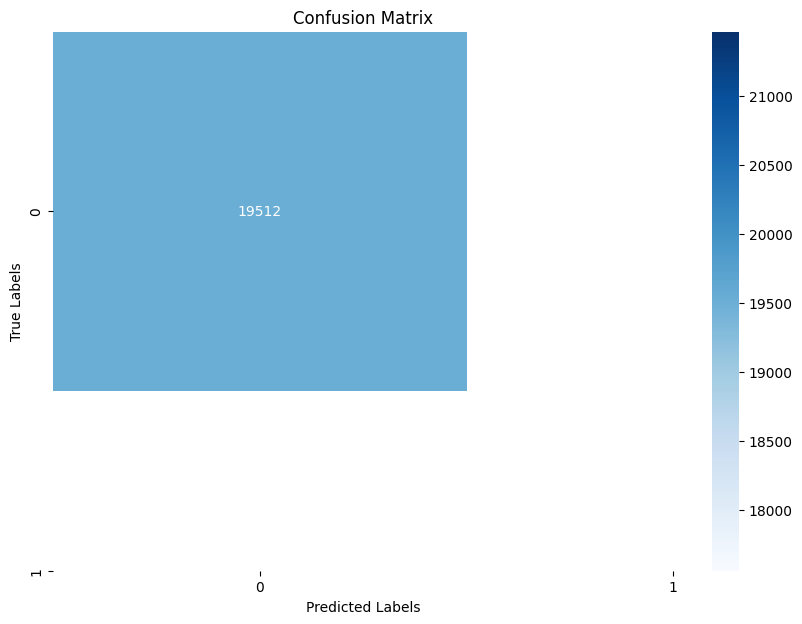

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_squared_error

# Compute MAE and MSE
test_mae = mean_absolute_error(labels_test, predictions)
test_mse = mean_squared_error(labels_test, predictions)

print(f'Test MAE: {test_mae}')
print(f'Test MSE: {test_mse}')

# Define a threshold for converting continuous predictions to binary
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
binary_labels_test = (labels_test > threshold).astype(int)

# Compute precision, recall, and F1 score
precision = precision_score(binary_labels_test, binary_predictions)
recall = recall_score(binary_labels_test, binary_predictions)
f1 = f1_score(binary_labels_test, binary_predictions)

print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1)

# Plot confusion matrix
cm = confusion_matrix(binary_labels_test, binary_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [10]:
import joblib

# Menyimpan model ke file
model_file_path = '../Models/UAS_model.keras'

# Save the model in HDF5 format
model.save(model_file_path)

print(f'Model telah diekspor dan disimpan di: {model_file_path}')


Model telah diekspor dan disimpan di: ../Models/UAS_model.keras


In [11]:
import numpy as np

# Generate 200 random numbers
random_numbers = np.random.rand(200)

# Convert to a comma-separated string
random_numbers_str = ", ".join(str(num) for num in random_numbers)

print(random_numbers_str)

0.8723413692390805, 0.4271693254280051, 0.938762484753866, 0.1062478686066336, 0.2513809210882777, 0.6659585624538598, 0.10184590212764122, 0.6756722864837886, 0.05529933170974577, 0.08956783386056677, 0.9765950016977908, 0.38443400232801095, 0.7596711705305693, 0.3322779651233344, 0.8379280089762441, 0.6905498733173675, 0.3170404952133956, 0.6875532577773016, 0.6065418845587729, 0.5157718437677355, 0.8820986557559237, 0.6734944541023355, 0.35375522802345305, 0.5282732460819881, 0.3968112314600565, 0.6830224610243288, 0.6247069661136216, 0.1838625812141671, 0.7628427082383775, 0.5226351012571965, 0.9331411054437614, 0.3180045655224627, 0.8672108809038402, 0.49688692572536686, 0.19778575361679862, 0.03999235836379378, 0.17556717248163012, 0.6808871121556448, 0.6947780018294253, 0.42851584843427826, 0.7751755321790309, 0.46191254859343955, 0.7782257118339536, 0.17339109547250897, 0.6444470983275484, 0.840206561931057, 0.3873766861734411, 0.6912045116997645, 0.9357172009408016, 0.33546779